# Classification with AG News Dataset from Kaggle
https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Observing data

In [ ]:
train_df = pd.read_csv("/data/train.csv")
test_df = pd.read_csv("/data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())

Train shape: (120000, 3)
Test shape: (7600, 3)
   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


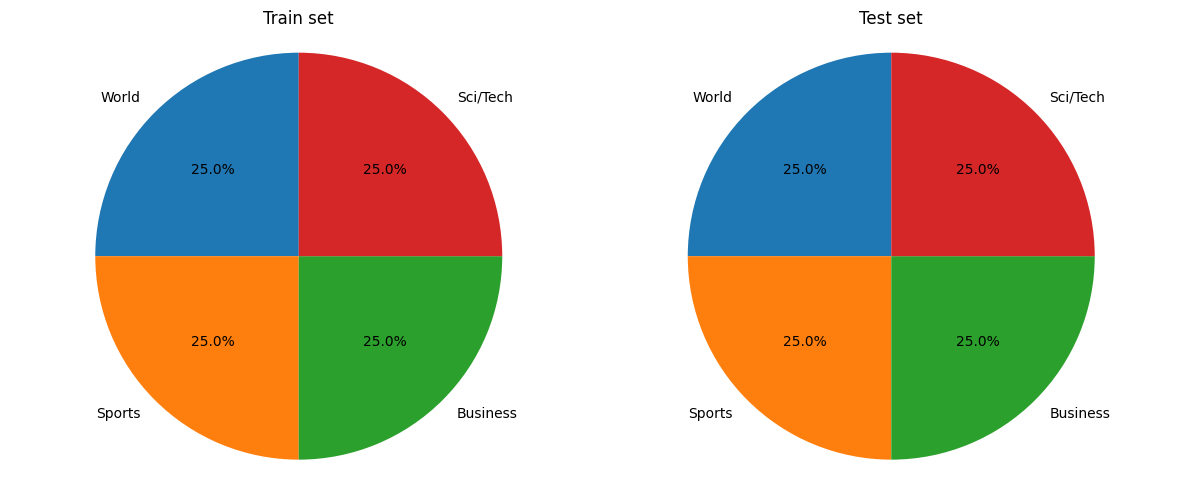

In [4]:
class_names = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
}

train_counts = train_df['Class Index'].value_counts().sort_index()
test_counts  = test_df['Class Index'].value_counts().sort_index()

train_labels = [class_names[i] for i in train_counts.index]
test_labels  = [class_names[i] for i in test_counts.index]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(
    train_counts,
    labels=train_labels,
    autopct="%.1f%%",
    startangle=90
)
plt.title("Train set")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.pie(
    test_counts,
    labels=test_labels,
    autopct="%.1f%%",
    startangle=90
)
plt.title("Test set")
plt.axis("equal")

plt.tight_layout()
plt.show()

## Preprocessing

### Features and labels

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = train_df["Title"] + " " + train_df["Description"]
y = train_df["Class Index"]

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Vectorize text
tạm dùng thư viện, nếu sau có thời gian thì tự code

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# lần 1
# vectorizer = TfidfVectorizer(
#     stop_words="english",
#     max_features=5000
# )

# lần 2
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=20000,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train_sub)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(
    test_df["Title"] + " " + test_df["Description"]
)

## Baseline use library `sklearn`

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Train model

In [10]:
baseline_model = LogisticRegression(max_iter=2000)
baseline_model.fit(X_train_tfidf, y_train_sub)

LogisticRegression(max_iter=2000)

### Predictions

In [11]:
val_pred = baseline_model.predict(X_val_tfidf)


Accuracy: 0.9218333333333333

Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.91      0.92      6000
           2       0.96      0.98      0.97      6000
           3       0.90      0.90      0.90      6000
           4       0.90      0.90      0.90      6000

    accuracy                           0.92     24000
   macro avg       0.92      0.92      0.92     24000
weighted avg       0.92      0.92      0.92     24000



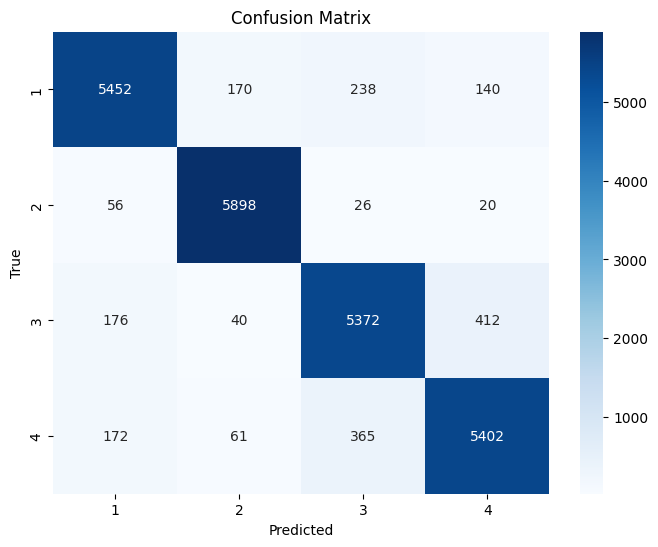

In [12]:
# Accuracy
acc_baseline = accuracy_score(y_val, val_pred)
print("\nAccuracy:", acc_baseline)

# Classification report
print("\nClassification Report:\n", classification_report(y_val, val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, val_pred, labels=baseline_model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=baseline_model.classes_, yticklabels=baseline_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Logistic Regression from Scratch

### Class Logistic Regression from Scratch

In [13]:
class LRfromScratch:
    def __init__(self, lr=0.1, iterations=1000, decay_rate=0.001):
        self.lr = lr
        self.iterations = iterations
        self.decay_rate = decay_rate
        self.weights = None
        self.bias = None
        self.loss_history = []


    def _sigmoid(self, z):
        # Clipping z để tránh lỗi overflow khi tính exp(-z)
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y, batch_size=1024):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        old_loss = float('inf')
        for i in range(self.iterations):
            # # # 1. Tính z và y_hat
            # z = X.dot(self.weights) + self.bias
            # y_hat = self._sigmoid(z)

            # # 2. Gradient descent
            # dw = (1 / n_samples) * X.T.dot(y_hat - y)
            # db = (1 / n_samples) * np.sum(y_hat - y)

            # self.weights -= self.lr * dw
            # self.bias -= self.lr * db
            # cải tiến lần 3:
            cur_lr = self.lr / (1 + self.decay_rate*i)
            # self.weights -= cur_lr * dw
            # self.bias -= cur_lr * db

            # cải tiến lần 4: mini batch
            indices = np.random.permutation(n_samples)

            for j in range(0, n_samples, batch_size):
                batch_idx = indices[j:j+batch_size]

                X_batch = X[batch_idx]
                y_batch = y[batch_idx]

                z = X_batch.dot(self.weights) + self.bias
                y_hat = self._sigmoid(z)

                diff = y_hat - y_batch
                dw = (1/len(batch_idx)) * X_batch.T.dot(diff)
                db = (1/len(batch_idx)) * np.sum(diff)

                self.weights -= cur_lr * dw
                self.bias -= cur_lr * db

            # Lưu loss để vẽ biểu đồ
            # if i % 100 == 0:
            #     loss = -np.mean(y * np.log(y_hat + 1e-15) + (1 - y) * np.log(1 - y_hat + 1e-15))
            #     self.loss_history.append(loss)
            #     print(f"Epoch {i} - Loss: {loss:.4f} - LR: {cur_lr:.5f}")
            if i % 100 == 0: # cho minibatch
                z_full = X.dot(self.weights) + self.bias
                y_hat_full = self._sigmoid(z_full)
                loss = -np.mean(y * np.log(y_hat_full + 1e-15) + (1 - y) * np.log(1 - y_hat_full + 1e-15))
                self.loss_history.append(loss)

                if abs(old_loss - loss) < 1e-6:
                  print(f"Dừng sớm tại Epoch {i}")
                  break;
                old_loss = loss

                print(f"Epoch {i} - Loss: {loss:.4f} - LR: {cur_lr:.5f}")

    def predict_proba(self, X):
        z = X.dot(self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return [1 if i > 0.5 else 0 for i in probabilities]

### One vs Rest

In [14]:
models = {}
classes = [1, 2, 3, 4]

for c in classes:
    print(f"Đang huấn luyện bộ phân loại cho lớp {c}...")
    # Biến bài toán thành nhị phân: Lớp c là 1, các lớp khác là 0
    y_train_binary = np.where(y_train_sub == c, 1, 0)

    model = LRfromScratch(lr=0.8, iterations=2000)
    model.fit(X_train_tfidf, y_train_binary, batch_size=1024)
    models[c] = model

final_probs = []
for c in classes:
    final_probs.append(models[c].predict_proba(X_val_tfidf))

final_probs = np.array(final_probs).T
val_pred_scratch = np.argmax(final_probs, axis=1) + 1

Đang huấn luyện bộ phân loại cho lớp 1...
Epoch 0 - Loss: 0.5420 - LR: 0.80000
Epoch 100 - Loss: 0.2019 - LR: 0.72727
Epoch 200 - Loss: 0.1696 - LR: 0.66667
Epoch 300 - Loss: 0.1554 - LR: 0.61538
Epoch 400 - Loss: 0.1468 - LR: 0.57143
Epoch 500 - Loss: 0.1408 - LR: 0.53333
Epoch 600 - Loss: 0.1364 - LR: 0.50000
Epoch 700 - Loss: 0.1329 - LR: 0.47059
Epoch 800 - Loss: 0.1300 - LR: 0.44444
Epoch 900 - Loss: 0.1276 - LR: 0.42105
Epoch 1000 - Loss: 0.1255 - LR: 0.40000
Epoch 1100 - Loss: 0.1237 - LR: 0.38095
Epoch 1200 - Loss: 0.1221 - LR: 0.36364
Epoch 1300 - Loss: 0.1207 - LR: 0.34783
Epoch 1400 - Loss: 0.1194 - LR: 0.33333
Epoch 1500 - Loss: 0.1183 - LR: 0.32000
Epoch 1600 - Loss: 0.1172 - LR: 0.30769
Epoch 1700 - Loss: 0.1162 - LR: 0.29630
Epoch 1800 - Loss: 0.1153 - LR: 0.28571
Epoch 1900 - Loss: 0.1145 - LR: 0.27586
Đang huấn luyện bộ phân loại cho lớp 2...
Epoch 0 - Loss: 0.5402 - LR: 0.80000
Epoch 100 - Loss: 0.1495 - LR: 0.72727
Epoch 200 - Loss: 0.1120 - LR: 0.66667
Epoch 300 - L

Accuracy (From Scratch): 0.920458

                precision  recall     f1-score   support   

1               0.93       0.91       0.92       6000      
2               0.95       0.98       0.97       6000      
3               0.89       0.89       0.89       6000      
4               0.90       0.90       0.90       6000      

accuracy                              0.92       24000     
macro avg       0.92       0.92       0.92       24000     
weighted avg    0.92       0.92       0.92       24000     


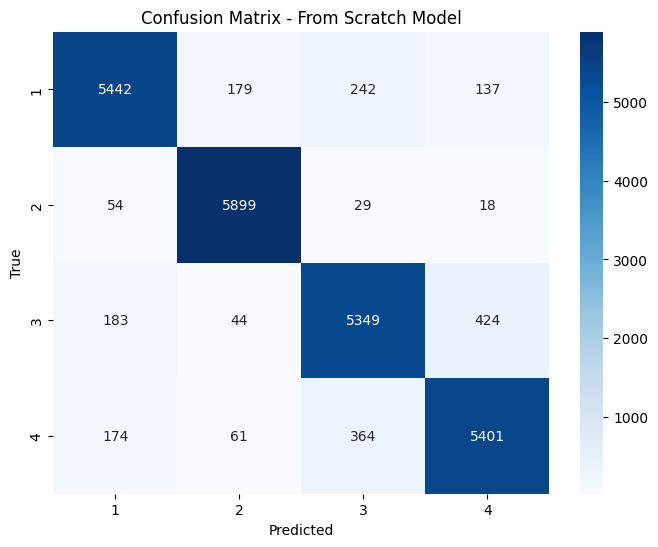

In [15]:
def manual_classification_report(y_true, y_pred, classes=[1, 2, 3, 4]):
    num_classes = len(classes)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    class_to_idx = {val: i for i, val in enumerate(classes)}
    for t, p in zip(y_true, y_pred):
        cm[class_to_idx[t]][class_to_idx[p]] += 1

    total_samples = len(y_true)
    acc_scratch = np.trace(cm) / total_samples

    print(f"Accuracy (From Scratch): {acc_scratch:.6f}\n")
    print(f"{'':<15} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<10}")
    print()

    metrics = []
    supports = []
    for i, c in enumerate(classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        sup = np.sum(cm[i, :])

        pre = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (pre * rec) / (pre + rec) if (pre + rec) > 0 else 0

        metrics.append([pre, rec, f1])
        supports.append(sup)
        print(f"{c:<15} {pre:<10.2f} {rec:<10.2f} {f1:<10.2f} {sup:<10}")

    metrics_arr = np.array(metrics)
    weights = np.array(supports) / total_samples
    macro_avg = np.mean(metrics_arr[:, :3], axis=0)
    weighted_avg = np.sum(metrics_arr * weights[:, np.newaxis], axis=0)

    print()
    print(f"{'accuracy':<15} {'':<10} {'':<10} {acc_scratch:<10.2f} {total_samples:<10}")
    print(f"{'macro avg':<15} {macro_avg[0]:<10.2f} {macro_avg[1]:<10.2f} {macro_avg[2]:<10.2f} {total_samples:<10}")
    print(f"{'weighted avg':<15} {weighted_avg[0]:<10.2f} {weighted_avg[1]:<10.2f} {weighted_avg[2]:<10.2f} {total_samples:<10}")

    return cm

# Thực thi
cm_scratch = manual_classification_report(y_val, val_pred_scratch)

acc_scratch = np.trace(cm_scratch)/len(y_val)


def plot_manual_cm(cm, classes=[1, 2, 3, 4]):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion Matrix - From Scratch Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_manual_cm(cm_scratch)

## So sánh Baseline vs FromScratch

### Trên tập test tách từ file `train.csv`

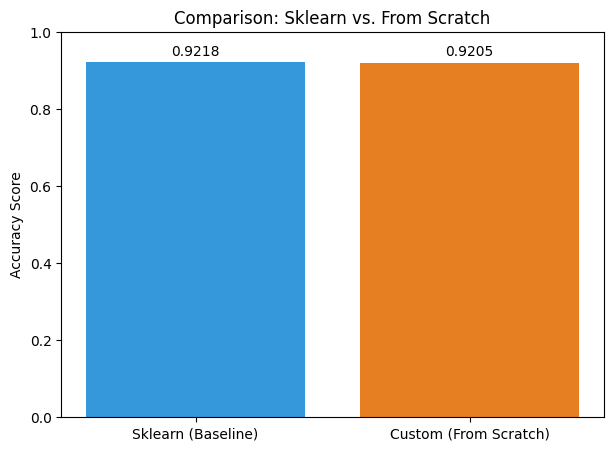

In [16]:
models_names = ['Sklearn (Baseline)', 'Custom (From Scratch)']
accuracies = [acc_baseline, acc_scratch]

plt.figure(figsize=(7, 5))
bars = plt.bar(models_names, accuracies, color=['#3498db', '#e67e22'])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy Score')
plt.title('Comparison: Sklearn vs. From Scratch')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

plt.show()

### Trên `test.csv`

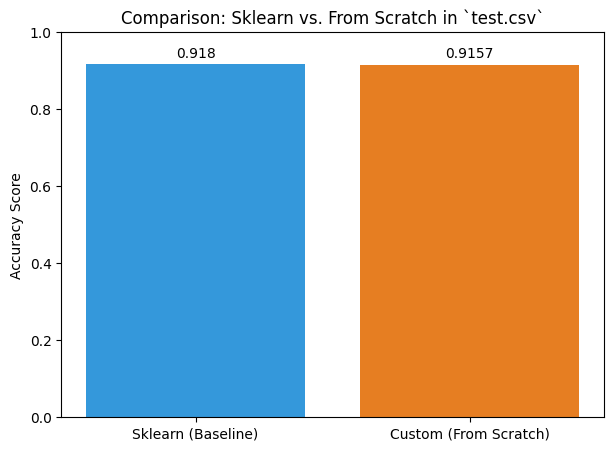

In [17]:
y_true_test = test_df["Class Index"]

baseline_test_pred = baseline_model.predict(X_test_tfidf)
acc_baseline = accuracy_score(y_true_test, baseline_test_pred)


X_val_dense_test = X_test_tfidf.toarray()
final_probs_test = []
for c in classes:
    final_probs_test.append(models[c].predict_proba(X_val_dense_test))

final_probs_test = np.array(final_probs_test).T
scratch_test_pred = np.argmax(final_probs_test, axis=1) + 1
acc_scratch = accuracy_score(y_true_test, scratch_test_pred)

models_names = ['Sklearn (Baseline)', 'Custom (From Scratch)']
accuracies = [acc_baseline, acc_scratch]

plt.figure(figsize=(7, 5))
bars = plt.bar(models_names, accuracies, color=['#3498db', '#e67e22'])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy Score')
plt.title('Comparison: Sklearn vs. From Scratch in `test.csv`')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

plt.show()

Accuracy (From Scratch): 0.915658

                precision  recall     f1-score   support   

1               0.93       0.91       0.92       1900      
2               0.95       0.98       0.97       1900      
3               0.89       0.88       0.88       1900      
4               0.90       0.89       0.89       1900      

accuracy                              0.92       7600      
macro avg       0.92       0.92       0.92       7600      
weighted avg    0.92       0.92       0.92       7600      


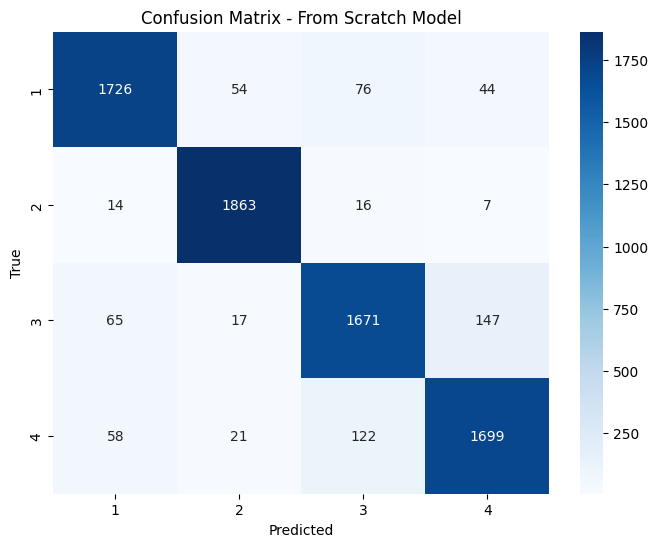

In [18]:
cm_scratch = manual_classification_report(y_true_test, scratch_test_pred)

acc_scratch = np.trace(cm_scratch)/len(y_true_test)


def plot_manual_cm(cm, classes=[1, 2, 3, 4]):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion Matrix - From Scratch Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_manual_cm(cm_scratch)


Accuracy: 0.9180263157894737

Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.91      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.89      0.88      0.89      1900
           4       0.90      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



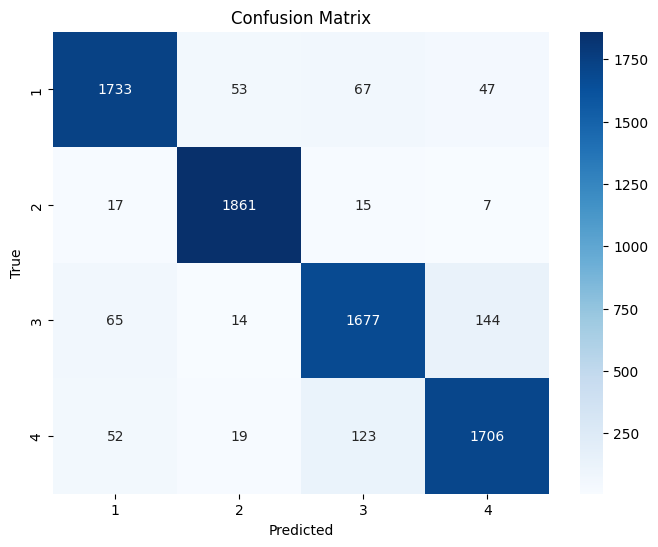

In [19]:
# Accuracy
acc_baseline = accuracy_score(y_true_test, baseline_test_pred)
print("\nAccuracy:", acc_baseline)

# Classification report
print("\nClassification Report:\n", classification_report(y_true_test, baseline_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_true_test, baseline_test_pred, labels=baseline_model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=baseline_model.classes_, yticklabels=baseline_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()